In [178]:
import pandas as pd
from matplotlib import pyplot as pp
import numpy as np
import datetime

In [179]:
df = pd.read_pickle("../recording.pkl")
df.reset_index(inplace=True)

# shortcuts
channel = ["channel{}".format(i) for i in range(8)]
highlighted = ["highlighted{}".format(i) for i in range(30)]
interval = "interval"
target = "target"
df.head()

,timestamp,channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,highlighted0,...,highlighted22,highlighted23,highlighted24,highlighted25,highlighted26,highlighted27,highlighted28,highlighted29,interval,target
0,2017-12-14 21:35:48.730677,-86,106,-142,-708,-119,125,35,-327,False,...,False,False,False,False,False,False,False,False,0,NaN
1,2017-12-14 21:35:48.730919,-95,109,-143,-214,55,41,-42,138,False,...,False,False,False,False,False,False,False,False,0,NaN
2,2017-12-14 21:35:48.731125,-74,114,-162,-277,-72,36,-102,-392,False,...,False,False,False,False,False,False,False,False,0,NaN
3,2017-12-14 21:35:48.731325,-63,132,-148,-711,-186,57,-49,-380,False,...,False,False,False,False,False,False,False,False,0,NaN
4,2017-12-14 21:35:48.731571,-97,114,-151,-201,8,-53,-133,112,False,...,False,False,False,False,False,False,False,False,0,NaN


In [180]:
df.describe()

,channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,interval,target
count,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,59987.000000
mean,-483.909400,-247.651141,-340.137349,3.318087,-122.923575,-211.208511,-328.916697,-31.194812,654.265310,12.543301
std,265.390576,563.530053,355.440709,1970.276956,1720.243609,1559.468701,923.210472,1939.633925,385.394148,7.619537
min,-2048.000000,-2048.000000,-2048.000000,-2048.000000,-2048.000000,-2048.000000,-2048.000000,-2048.000000,0.000000,0.000000
25%,-653.000000,-546.000000,-562.000000,-2048.000000,-2048.000000,-1976.000000,-1010.000000,-2048.000000,319.000000,7.000000
50%,-487.000000,-265.000000,-350.000000,24.000000,-242.000000,-329.000000,-333.000000,-169.000000,660.000000,11.000000
75%,-319.000000,27.000000,-136.000000,2047.000000,1922.000000,1328.000000,328.000000,2047.000000,987.000000,19.000000
max,1979.000000,2047.000000,2047.000000,2047.000000,2047.000000,2047.000000,2047.000000,2047.000000,1320.000000,26.000000


In [181]:
df = df.select(lambda col: col not in channel or col in ["channel0", "channel1", "channel2"], axis=1)
channel = [c for c in channel if c in df.columns]

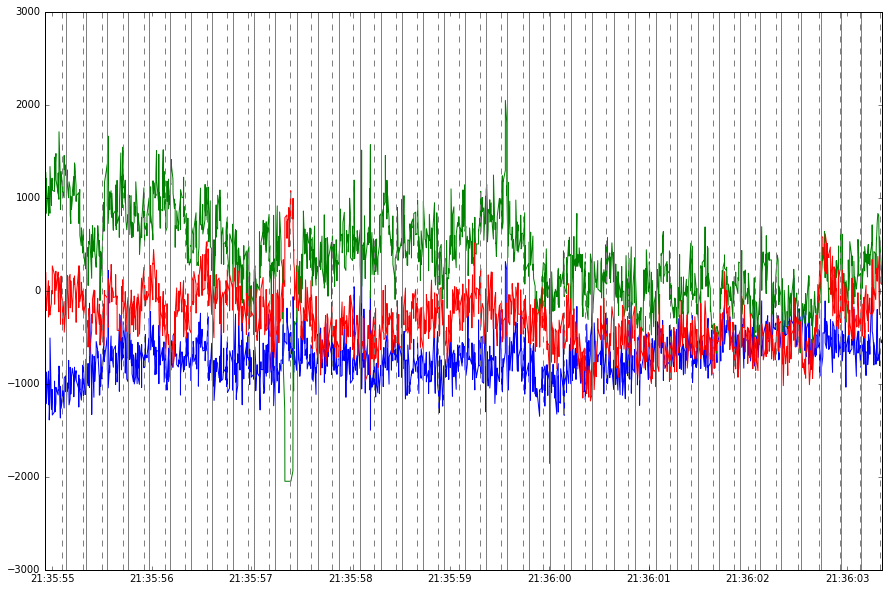

In [182]:
trial_info = df.groupby(["interval"], axis=0).first()[highlighted+[target, "timestamp"]]
trial_starts = trial_info["timestamp"]
trial_one_sec = trial_starts + datetime.timedelta(seconds=1)

pp.figure(figsize=(15,10))
pp.plot(df["timestamp"], df[channel].values)
trial_starts.map(lambda x: pp.axvline(x, color="gray", linestyle="solid"))
trial_one_sec.map(lambda x: pp.axvline(x, color="gray", linestyle="dashed"))
pp.xlim(trial_starts[10], trial_starts[50])
pp.show()

In [183]:
df.set_index("timestamp", inplace=True)

In [184]:
intervals = []
for start,end in zip(trial_starts, trial_one_sec):
    # redistribute sample points
    chunk = df[start:end][channel]
    chunk.set_index(pd.to_datetime(np.linspace(start.value, end.value, len(chunk), endpoint=True))-start, inplace=True)
    chunk = chunk.resample("4L").pad()#.interpolate(method="linear")
    intervals.append(chunk)

In [185]:
target_intervals = []
nottarget_intervals = []
for i,interval in enumerate(intervals):
    target = trial_info["target"].loc[i]
    if np.isnan(target):
        continue
    
    if trial_info[highlighted[int(target)]].loc[i]:
        target_intervals.append(interval.values)
    else:
        nottarget_intervals.append(interval.values)
        
target_intervals = np.array(target_intervals, dtype=float)
nottarget_intervals = np.array(nottarget_intervals, dtype=float)

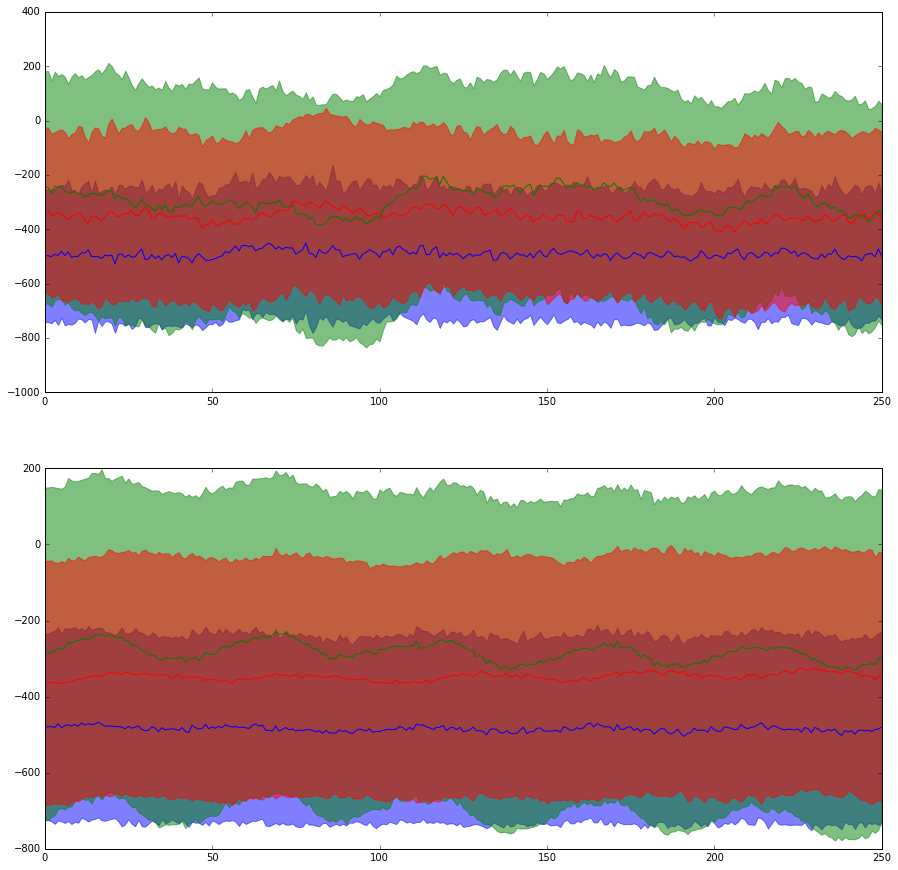

In [186]:
target_mean = target_intervals.mean(axis=0)
target_std  = target_intervals.std(axis=0)
nottarget_mean = nottarget_intervals.mean(axis=0)
nottarget_std  = nottarget_intervals.std(axis=0)

pp.figure(figsize=(15,15))
pp.subplot(211)
lines = pp.plot(target_mean)
for i,l in enumerate(lines):
    pp.fill_between(np.arange(len(target_mean)),target_mean[:,i]-target_std[:,i],target_mean[:,i]+target_std[:,i], color=l.get_color(), alpha=0.5)
pp.subplot(212)
lines = pp.plot(nottarget_mean)
for i,l in enumerate(lines):
    pp.fill_between(np.arange(len(target_mean)),nottarget_mean[:,i]-nottarget_std[:,i],nottarget_mean[:,i]+nottarget_std[:,i], color=l.get_color(), alpha=0.5)
pp.show()

In [159]:
len(target_intervals)

240